In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import pacf as pacf_func
from statsmodels.graphics.tsaplots import acf as acf_func
import statsmodels.graphics.tsaplots as tsa

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

import MetaTrader5 as mt5
from statsmodels.tsa.arima.model import ARIMA
plt.style.use('ggplot')

import plotly.graph_objects as go

# <font face="gotham" color="purple"> AR Model </font>

We have introduced $\text{AR}$ and $\text{MA}$ models in previous chapters, in this chapter we will discuss the practical issues of both models.
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
If $\phi<0$, the time series exhibits mean-reversion feature, if $\phi>0$ exhibits trend-following feature. One reminder, ```ArmaProcess``` needs zero lag coefficient $1$ to be input explicitly and the sign from lag $1$ onward must be sign-reversed.

In [2]:
ar_params = np.array([1, 0.9])
ma_params = np.array([1])
ar1 = ArmaProcess(ar_params, ma_params)
ar1_sim = ar1.generate_sample(nsample=100)
ar1_sim = pd.DataFrame(ar1_sim, columns = ['AR(1)'])
ar1_acf = acf_func(ar1_sim.values, fft=False, nlags = 50)

ar_params1 = np.array([1, -0.9])
ma_params1 = np.array([1])
ar1_pos = ArmaProcess(ar_params1, ma_params1)
ar1_sim_pos = ar1_pos.generate_sample(nsample=100)
ar1_sim_pos = pd.DataFrame(ar1_sim_pos, columns = ['AR(1)'])
ar1_acf_pos = acf_func(ar1_sim_pos.values, fft=False, nlags = 50)

ar_params2 = np.array([1, -0.8, -.2])
ma_params2 = np.array([1])
ar2 = ArmaProcess(ar_params2, ma_params2)
ar2_sim = ar2.generate_sample(nsample=100)
ar2_sim = pd.DataFrame(ar2_sim, columns = ['AR(2)'])
ar2_acf = acf_func(ar2_sim.values, fft=False, nlags = 50)

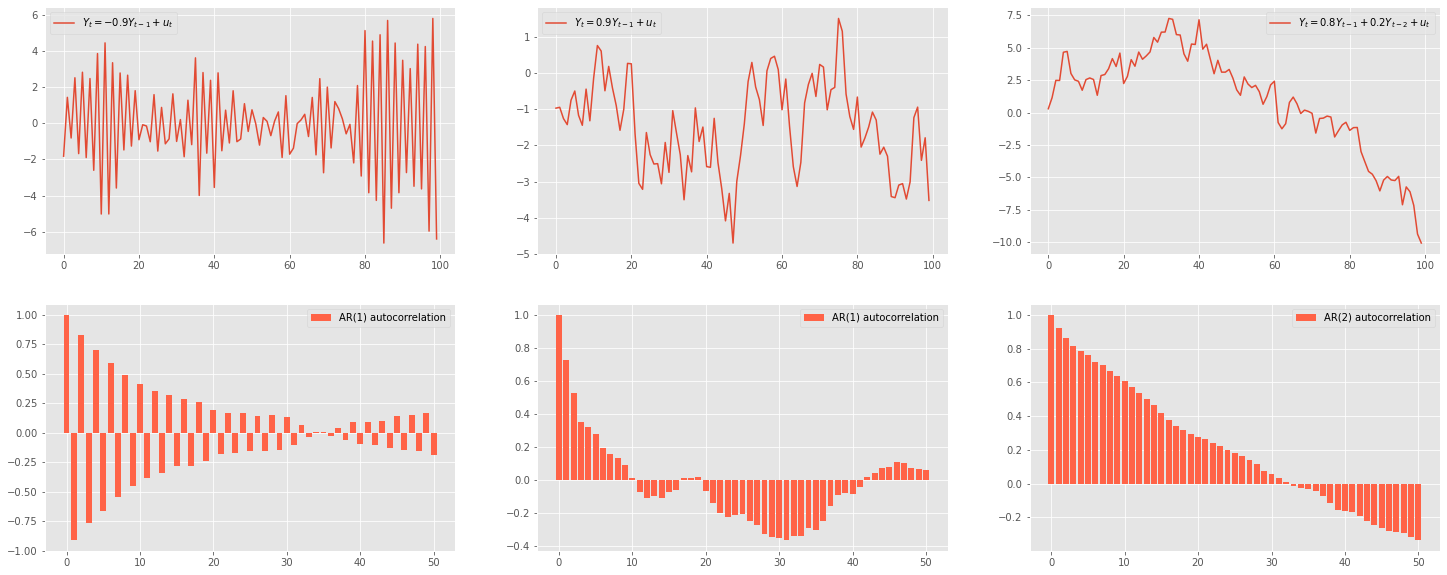

In [3]:
fig, ax = plt.subplots(figsize = (25, 10), nrows = 2, ncols = 3)
ax[0, 0].plot(ar1_sim, label='$Y_t = {%s}Y_{t-1}+u_t$'%(-ar_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(np.arange(len(ar1_acf)),ar1_acf, color = 'tomato', label = 'AR(1) autocorrelation')
ax[1, 0].legend()

ax[0, 1].plot(ar1_sim_pos, label='$Y_t = {%s}Y_{t-1}+u_t$'%(-ar_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(np.arange(len(ar1_acf_pos)),ar1_acf_pos, color = 'tomato', label = 'AR(1) autocorrelation')
ax[1, 1].legend()

ax[0, 2].plot(ar2_sim, label='$Y_t = {%s} Y_{t-1}+{%s} Y_{t-2}+u_t$'%(-ar_params2[1], -ar_params2[2]))
ax[0, 2].legend()
ax[1, 2].bar(np.arange(len(ar2_acf)),ar2_acf, color = 'tomato', label = 'AR(2) autocorrelation')
ax[1, 2].legend()
plt.show()

# <font face="gotham" color="purple">  Estimation and Forecast of AR</font> 

Output ```sigma2``` is the variance of residuals. 

In [4]:
mod_obj = ARIMA(ar1_sim_pos, order=(1, 0, 0))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(1)   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -126.554
Date:                Sun, 02 Jan 2022   AIC                            259.109
Time:                        13:38:26   BIC                            266.924
Sample:                             0   HQIC                           262.272
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5068      0.325     -4.638      0.000      -2.144      -0.870
ar.L1          0.7373      0.074      9.947      0.000       0.592       0.883
sigma2         0.7300      0.127      5.742      0.0

In [5]:
res_predict = result.predict(start=5, end=110)

In [6]:
ar1_sim_pos.plot(figsize=(16, 8))
res_predict.plot(label = 'in-/out-sample forecast', title='Prediction And Forecast of AR(1)')
plt.legend()
plt.show()

# <font face="gotham" color="purple">Identification of the Order of an AR Model </font>

The usual practice of order identification is called **the Box-Jenkins Methodology**, which will be explicated below, for now we simply perform two techniques:
1. Partial Autocorrelation Function
2. Akaike or Bayesian Information Criteria ($\text{AIC}$, $\text{BIC}$)

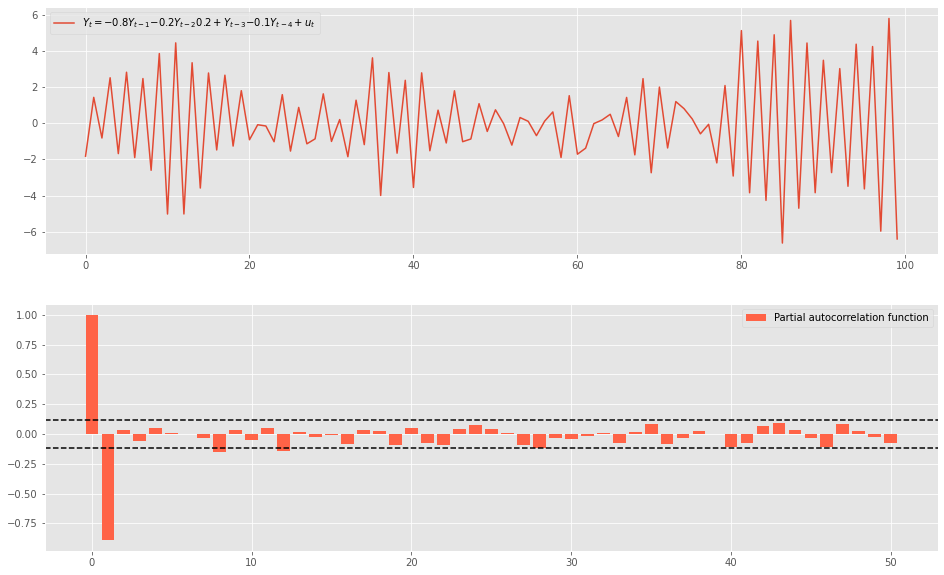

In [7]:
obs = 300

ar_params = np.array([1, 0.8, 0.2, -.2, .1])
ma_params = np.array([1])
ar4 = ArmaProcess(ar_params, ma_params)
ar4_sim = ar1.generate_sample(nsample=obs)
ar4_sim = pd.DataFrame(ar4_sim, columns = ['AR(4)'])
ar4_pacf = pacf_func(ar4_sim.values, nlags = 50)


fig, ax = plt.subplots(figsize = (16, 10), nrows = 2, ncols = 1)
ax[0].plot(ar1_sim, 
           label='$Y_t = {%s}Y_{t-1} {%s}Y_{t-2} {%s}+Y_{t-3} {%s}Y_{t-4}+u_t$'%(-ar_params[1], -ar_params[2], -ar_params[3], -ar_params[4]))
ax[0].legend()
ax[1].bar(np.arange(len(ar4_pacf)),ar4_pacf, color = 'tomato', label = 'Partial autocorrelation function')
ax[1].axhline(y=2/np.sqrt(obs), linestyle='--', color='k')
ax[1].axhline(y=-2/np.sqrt(obs), linestyle='--', color='k')
ax[1].legend()
plt.show()

Only lag $1$ is significant, we could estimate it with $\text{AR(1)}$, the better idea is to loop the estimation to plot the $\text{AIC}$ and $\text{BIC}$.

In [8]:
aic, bic = [], []
for i in range(10):
    mod_obj = ARIMA(ar4_sim, order=(i, 0, 0))
    result = mod_obj.fit()
    aic.append(result.aic)
    bic.append(result.bic)

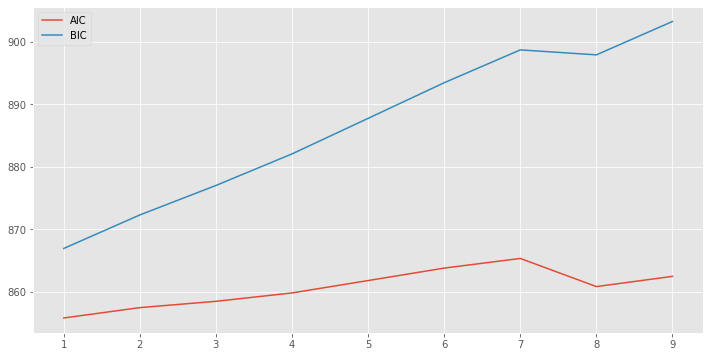

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1,10), aic[1:10], label='AIC')
ax.plot(range(1,10), bic[1:10], label='BIC')
ax.legend()
plt.show()

$\text{BIC}$ is monotonically increasing, $\text{AIC}$ reaches the lowest at the second lag, however we always choose the simpler model to fit, in this case an $\text{AR(1)}$ model.

In [10]:
mod_obj = ARIMA(ar4_sim, order=(1, 0, 0))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(4)   No. Observations:                  300
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -424.912
Date:                Sun, 02 Jan 2022   AIC                            855.825
Time:                        13:38:30   BIC                            866.936
Sample:                             0   HQIC                           860.271
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0231      0.031      0.739      0.460      -0.038       0.084
ar.L1         -0.8811      0.028    -31.923      0.000      -0.935      -0.827
sigma2         0.9899      0.090     11.004      0.0

# <font face="gotham" color="purple"> Meta Trader 5 Data </font>

If you have a MetaTrader 5 account, install the ```MetaTrader5``` library, then run the codes below to login the account.
```
import MetaTrader5 as mt5
login = 123456
password = 'abcdefgh'
server = 'XXXXXXX-Demo'
 
mt5.initialize()
mt5.login(login, password, server)
```

Then you can retrieve high frequency data from your broker's server, for instance here we retrieve one minute candlesticks data of $\text{USDJPY}$. ```start_bar``` means the current bar, ```num_bars``` is the number of bars all before the current bar.

```
symbol = 'USDJPY'
timeframe = 1
start_bar = 0
num_bars = 5000
 bars = mt5.copy_rates_from_pos(symbol, timeframe, start_bar, num_bars)
```

Because the time column is present in Unix timestamp, some conversion has to be done as below

```
kbars = pd.DataFrame(bars)

time =[]
for i in range(len(kbars['time'])):
    time.append(dt.datetime.fromtimestamp(kbars['time'][i]))
    
kbars['time'] = time
```

If you need it for later research, save it as a ```.csv``` file
```
kbars.to_csv('USDJPY_1m.csv', index=False)
```

I have uploaded this dataset onto repository.

In [11]:
usdjpy = pd.read_csv('USDJPY_1m.csv')

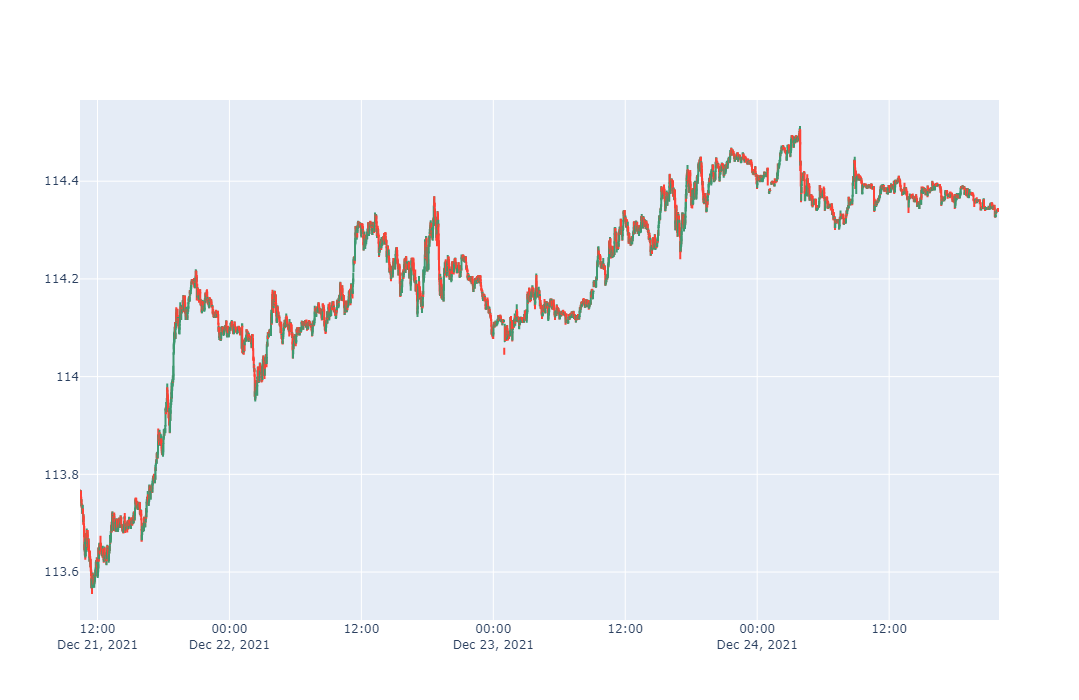

In [12]:
fig = go.Figure(data=[go.Candlestick(x=usdjpy['time'],
                open=usdjpy['open'],
                high=usdjpy['high'],
                low=usdjpy['low'],
                close=usdjpy['close'])])

fig.update_layout(
    xaxis_rangeslider_visible=False,
    autosize=False,
    width=1100,
    height=700
)

fig.show()

# <font face="gotham" color="purple"> MA Model </font>

Here is an $\text{MA(1)}$ model
$$
Y_{t}= u_{t}+\theta_{1} u_{t-1}
$$

In [13]:
ar_params = np.array([1])
ma_params = np.array([1, 0.9])
ma1 = ArmaProcess(ar_params, ma_params)
ma1_sim = ma1.generate_sample(nsample=100)
ma1_sim = pd.DataFrame(ma1_sim, columns = ['MA(1)'])
ma1_acf = acf_func(ma1_sim.values, fft=False, nlags = 50)

ar_params1 = np.array([1])
ma_params1 = np.array([1, -0.9])
ma1_neg = ArmaProcess(ar_params1, ma_params1)
ma1_sim_neg = ma1_neg.generate_sample(nsample=100)
ma1_sim_neg = pd.DataFrame(ma1_sim_neg, columns = ['MA(1)'])
ma1_acf_neg = acf_func(ma1_sim_neg.values, fft=False, nlags = 50)

ar_params2 = np.array([1])
ma_params2 = np.array([1, 0.8, .2])
ma2 = ArmaProcess(ar_params2, ma_params2)
ma2_sim = ma2.generate_sample(nsample=100)
ma2_sim = pd.DataFrame(ma2_sim, columns = ['MA(2)'])
ma2_acf = acf_func(ma2_sim.values, fft=False, nlags = 50)

In [14]:
fig, ax = plt.subplots(figsize = (25, 10), nrows = 2, ncols = 3)
ax[0, 0].plot(ma1_sim, label='$Y_t = u_t + {%s} u_{t-1}$'%(ma_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(np.arange(len(ma1_acf)),ma1_acf, color = 'tomato', label = 'MA(1) autocorrelation')
ax[1, 0].legend()

ax[0, 1].plot(ma1_sim_neg, label='$Y_t =  u_t  {%s} u_{t-1}$'%(ma_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(np.arange(len(ma1_acf_neg)),ma1_acf_neg, color = 'tomato', label = 'MA(1) autocorrelation')
ax[1, 1].legend()

ax[0, 2].plot(ma2_sim, label='$Y_t =  u_t   +{%s} u_{t-1}+ {%s} u_{t-2}  $'%(ma_params2[1], ma_params2[2]))
ax[0, 2].legend()
ax[1, 2].bar(np.arange(len(ma2_acf)),ma2_acf, color = 'tomato', label = 'MA(2) autocorrelation')
ax[1, 2].legend()
plt.show()

# <font face="gotham" color="purple">  Estimation and Forecast of MA</font> 

In [15]:
mod_obj = ARIMA(ma1_sim_neg, order=(0, 0, 1))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  MA(1)   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -123.832
Date:                Sun, 02 Jan 2022   AIC                            253.665
Time:                        13:38:36   BIC                            261.480
Sample:                             0   HQIC                           256.828
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.004     -0.274      0.784      -0.009       0.007
ma.L1         -0.9999     22.435     -0.045      0.964     -44.971      42.971
sigma2         0.6654     14.946      0.045      0.9

In [16]:
res_predict = result.predict(start=5, end=110)

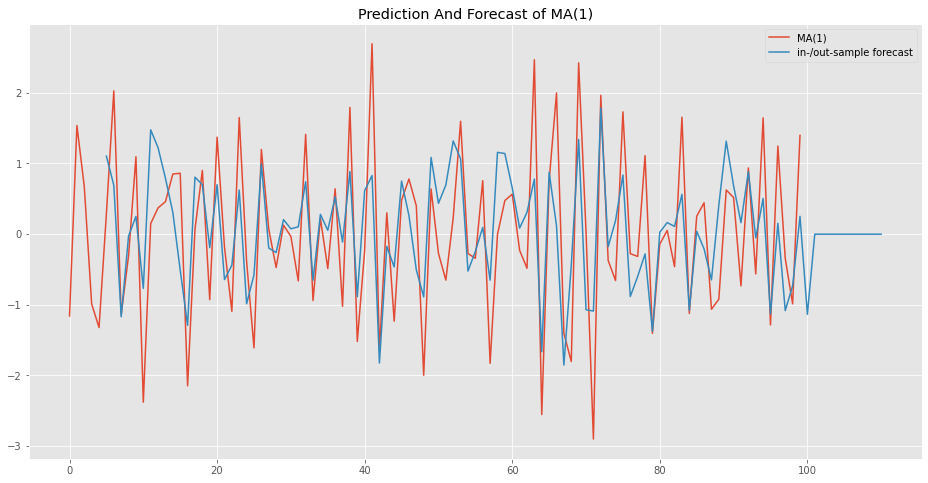

In [17]:
ma1_sim_neg.plot(figsize=(16, 8))
res_predict.plot(label = 'in-/out-sample forecast', title='Prediction And Forecast of MA(1)')
plt.legend()
plt.show()

Note that all forecasts beyond one-step ahead forecast will all be the same, namely a straight line.

# <font face="gotham" color="purple"> Connection of AR and MA </font>

We can show any $\text{AR(1)}$ can be rewritten as an $\text{MA($\infty$)}$ model
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
Perform a recursive substitution
\begin{align}
y_t &= \phi_0 + \phi_1(\phi_0 + \phi_1y_{t-2}+u_{t-1})+u_t = \phi_0 + \phi_1\phi_0+\phi_1^2y_{t-2}+\phi_1u_{t-1}+u_t\\
    &= \phi_0 + \phi_1\phi_0+\phi_1^2(\phi_0+\phi_1y_{t-3}+u_{t-2})+\phi_1u_{t-1}+u_t=\phi_0 + \phi_1\phi_0 +\phi_1^2\phi_0 +\phi_1^3y_{t-3}+\phi_1^2u_{t-2}+\phi_1u_{t-1}+u_t\\
    &\qquad\vdots\\
    &=\frac{\phi_0}{1-\phi_1}+\sum_{i=0}^\infty\phi_1^iu_{t-1}
\end{align}
It holds because of the fact
$$
\lim_{i\rightarrow\infty}\phi_1^iy_{t-i}=0
$$

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
ar = np.array([1])
ma = np.array([.8**i for i in range(100)])
mod_obj = ArmaProcess(ar, ma)
ma_sim = mod_obj.generate_sample(nsample=200)
g = plot_acf(ma_sim, ax = ax[0], lags = 50, title ='$MA(\infty), \phi_i = .9^i, i\in \mathbb{Z}^+$')

ar = np.array([1, -.8])
ma = np.array([1])
mod_obj = ArmaProcess(ar, ma)
ar_sim = mod_obj.generate_sample(nsample=200)
g = plot_acf(ar_sim, ax = ax[1], lags = 50, title = '$AR(1), \phi=.9$')

# <font face="gotham" color="purple"> ARMA and ARIMA </font>

Now we combine $\text{AR}$ and $\text{MA}$ models as $\text{ARMA}$ and $\text{ARMIA}$.

An $\text{ARMA}(1,1)$ process is a combination of $\text{AR}$ and $\text{MA}$
$$
Y_{t}=\phi_0+\phi_{1} Y_{t-1}+\theta_{0} u_{t}+\theta_{1} u_{t-1}
$$

In general, $\text{ARMA}(p,q)$ process has the form
$$
Y_t = \phi_0 + \phi_i\sum_{i=1}^pY_{t-i}+\sum_{i=1}^q\theta_i u_{t-i}
$$

And $\text{ARIMA}$ model is essentially the same as $\text{ARMA}$, if we have to difference a series $d$ times to render it stationary then apply the $\text{ARIMA}$ model, we say that the original time series is $\text{ARIMA}(p,d,q)$. 

With the same token, $\text{ARIMA}(p,0,q)$ process is the same as $\text{ARMA}(p,q)$.

In [19]:
usdjpy = pd.read_csv('USDJPY_1m.csv')

In [20]:
usdjpy_close = usdjpy['close'].dropna()

In [21]:
mod_obj = ARIMA(usdjpy_close, order=(2,1,2))

In [22]:
results = mod_obj.fit()

In [23]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 5000
Model:                 ARIMA(2, 1, 2)   Log Likelihood               17568.668
Date:                Sun, 02 Jan 2022   AIC                         -35127.336
Time:                        13:38:40   BIC                         -35094.751
Sample:                             0   HQIC                        -35115.915
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.553      1.785      0.074      -0.097       2.070
ar.L2         -0.2962      0.530     -0.559      0.576      -1.334       0.742
ma.L1         -0.9737      0.555     -1.753      0.0

<AxesSubplot:>

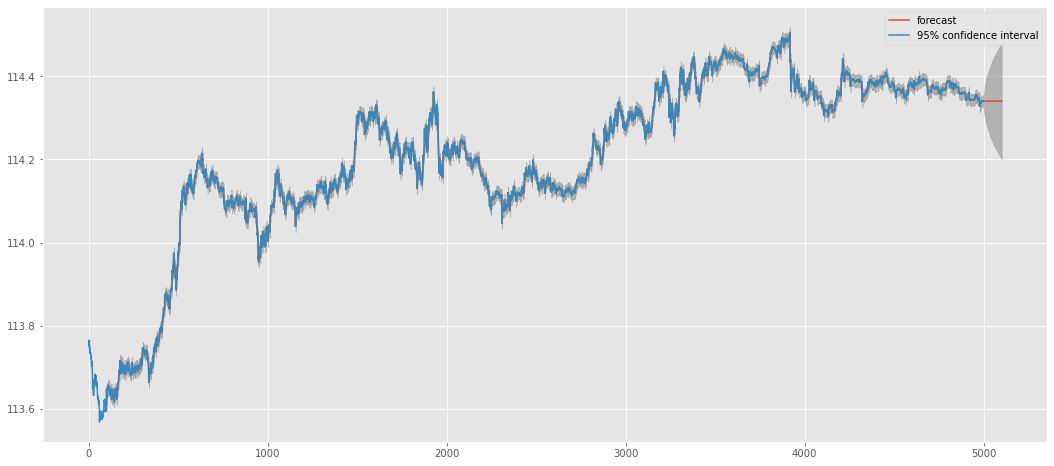

In [24]:
g = tsa.plot_predict(results, 100, 5100)
usdjpy_close.plot(figsize=(18, 8))

# <font face="gotham" color="purple"> The Box-Jenkins Methodology </font>

With so many options at hands, what model to apply to a time series? This is where **Box-Jenkins Methodology** kick in, which provides a systematic method of **identifying**, **estimating** and **checking** with $\text{ARIMA}$ models. 

## <font face="gotham" color="purple"> ACF VS PACF </font>

Before discussion of $\text{ARIMA}$ identification, we should understand the difference of **autocorrelation function** (ACF) and **partial autocorrelation function** (PACF), which both are important tools for identifying lags of $\text{ARIMA}$.

We have shown that the formula of sample ACF
\begin{aligned}
&\hat{\gamma}_{k}=\frac{\sum\left(Y_{t}-\bar{Y}\right)\left(Y_{t+k}-\bar{Y}\right)}{n-k} \\
&\hat{\gamma}_{0}=\frac{\sum\left(Y_{t}-\bar{Y}\right)^{2}}{n-1}\\
&\hat{\rho}_{k} =\frac{\hat{\gamma}_{k}}{\hat{\gamma}_{0}}=\frac{\text { covariance at lag } k}{\text { variance }}
\end{aligned}

However, PACF doesn't have a formula. Simply speaking, PACF requires removing all correlations in between. e.g. if you are measuring variables $k$ periods apart, then all influences from other variables in period $<k$ should be eliminated.

Regression with demeaned variables can give us the partial autocorrelation, e.g. 
$$
y_t-\bar{y}=\phi_{21} (y_{t-1}-\bar{y})+\phi_{22} (y_{t-2}-\bar{y})+\phi_{33} (y_{t-3}-\bar{y})+u_{t}
$$
Estimates of $\phi_{kk}$ is the partial correlation at lag $3$.

So how to use ACF and PACF to identify the lags of $\text{ARMA}$ model? First we transform the original data into log difference, then plot both correlograms. 

In [25]:
start = dt.datetime(1980, 1, 1)
end = dt.datetime(2021,10, 1)
df_cpi = pdr.data.DataReader(['CPIAUCSL'], 'fred' , start, end)
df_cpi.columns = ['urban_CPI']
df_cpi = df_cpi.dropna()

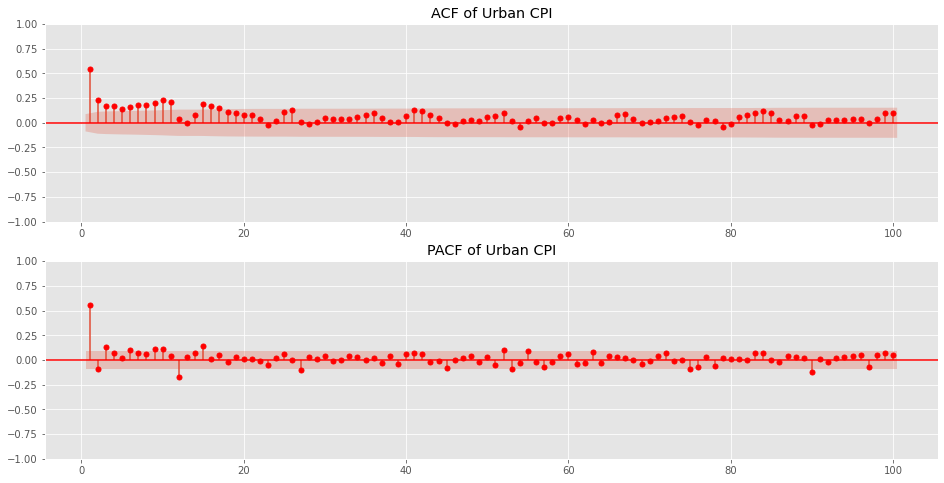

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
fig = plot_acf(np.log(df_cpi).diff().dropna(), ax=ax[0],
         lags=100, color = 'red', zero = False, 
         title ='ACF of Urban CPI')
fig = plot_pacf(np.log(df_cpi).diff().dropna(), ax=ax[1],
          lags=100, color = 'red', zero = False, 
          title ='PACF of Urban CPI', method ='ols')

## <font face="gotham" color="purple"> Simulation of ACF and PACF </font>

In [27]:
arparams = np.array([[.63, -.5], 
                     [-.23, .8],
                     [-.5, -.5]])
maparams = np.array([[.58, .45],
                     [.78, .34],
                     [.8, .8]])

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 5))
fig.tight_layout(pad=2.0)
ar = np.r_[1, -arparams[0]]
ma = np.r_[1, maparams[0]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
fig = plot_acf(arma22, ax = ax[0, 0])
fig = plot_pacf(arma22, ax = ax[1, 0], method ='ols')

ar = np.r_[1, -arparams[1]]
ma = np.r_[1, maparams[1]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
fig = plot_acf(arma22, ax = ax[0, 1])
fig = plot_pacf(arma22, ax = ax[1, 1], method ='ols')

ar = np.r_[1, -arparams[2]]
ma = np.r_[1, maparams[2]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
fig = plot_acf(arma22, ax = ax[0, 2])
fig = plot_pacf(arma22, ax = ax[1, 2], method ='ols')

How you set the parameters has to be consistent with lag operator form of $\text{ARMA}$ model as below, which is the exact reason we set the opposite sign of $\phi$'s.

$$
\left(1-\phi_{1}L-\ldots-\phi_{p}L^{p}\right)y_{t} =
        \left(1+\theta_{1}L+\ldots+\theta_{q}L^{q}\right)\varepsilon_{t}
$$

## <font face="gotham" color="purple"> Identification of ARMA </font>

The identification of $\text{ARMA}$ doesn't have clear-cut rules, but here are four guideline to help you decide the lags of $\text{ARMA}$ model.
1. If PACF shows significant lags through $p$ and ACF dampens exponentially, try $\text{AR}(p)$
2. If ACF shows significant lags through $q$ and PACF dampens exponentially, try $\text{MA}(q)$
3. Both ACF and PACF dampen exponentially with significant lags $(p, q)$, try $\text{ARMA}(p, q)$ 